# SHAP

>SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

In [ ]:
!pip install shap xgboost

## 🤖 XGBoost
Let's start with simple. XGBoost is quite simple yet effective model.  
However, the interface itself is the same for most of the supported model. 

In [1]:
import xgboost
import shap

# Init JS for interactive plots
shap.initjs()

In [ ]:
# train an XGBoost model
X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

### Overall model unverstanding
These plot shows the overall model understanding, how each feature contributes to the model.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


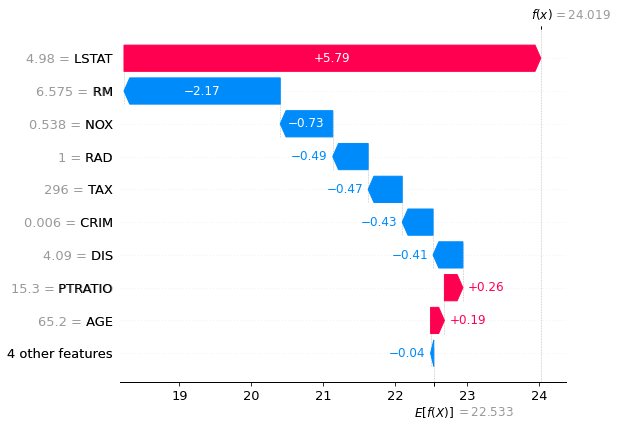

In [3]:
## Use this codeblock for setting the dpi of the figure
# # visualize the first prediction's explanation
# fig = shap.plots.waterfall(shap_values[0],show = False)
# # set dpi of the figure for better resolution ;) 
# fig.set_dpi(100)

# ------------------------------------------------------------
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[0])

Force plot

In [4]:
shap.plots.force(shap_values[0])

### Per-input understanding
These plot shows the per-input understanding, how each feature contributes to the prediction of a single input.

In [5]:
# visualize all the training set predictions
shap.plots.force(shap_values)

Not very useful usually, so we can create such plot for one feature only.  
On the exmaple below, we plot the contribution of the feature `RM (room number)` to the output price. Horizontal axis is the value of the feature, vertical axis is the contribution of the feature == weight. 

We can also colorcode the plot by another feature. SHAP library do this automatically, by picking the best dependecy. Here it picked `RAD` (index of accessibility to radial highways).

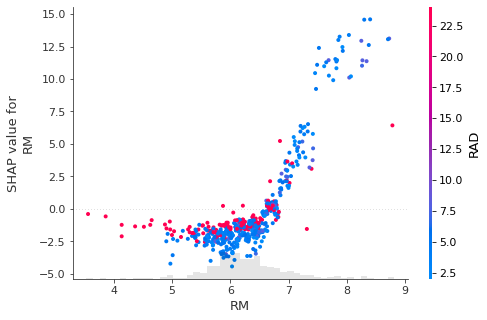

In [7]:
shap.plots.scatter(shap_values[:,"RM"], color=shap_values)

Another possible stategy to check the weights of each feature for a single input. Here we can see the distribution of the weights for each feature and their approximate values.

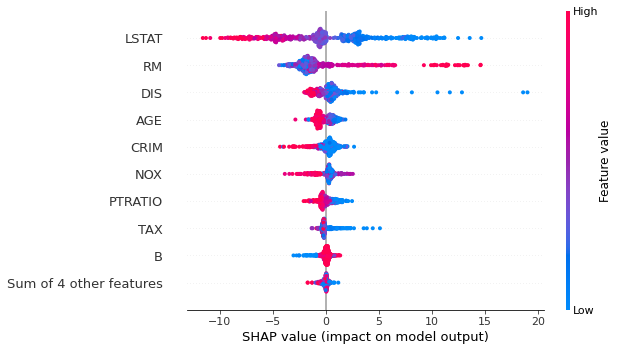

In [8]:
shap.plots.beeswarm(shap_values)

Taking the mean value of the weight is also possible. Just in case we want to measure the average attribution of each feature.

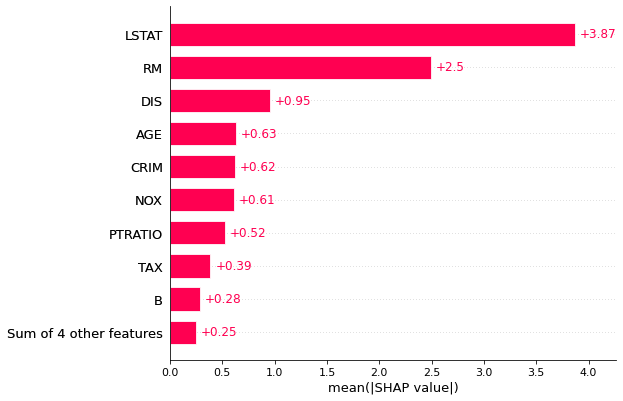

In [9]:
shap.plots.bar(shap_values)

## 📝 NLP

#### 📊 **Text classification**

In [10]:
import transformers
import shap

# load a transformers pipeline model
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

# explain the model on two sample inputs
explainer = shap.Explainer(model) 
shap_values = explainer(["What a great movie! ...if you have no taste."])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


  0%|          | 0/240 [00:00<?, ?it/s]

Partition explainer: 2it [00:13, 14.00s/it]               


#### ❓ **QA**

In [15]:
import torch

## UTIL FUNCTIONS
# ------------------------------------------------------------
# define two predictions, one that outputs the logits for the range start,
# and the other for the range end
def f(questions, start):
    outs = []
    for q in questions:
        question, context = q.split("[SEP]")
        d = pmodel.tokenizer(question, context)
        out = pmodel.model.forward(**{k: torch.tensor(d[k]).reshape(1, -1) for k in d})
        logits = out.start_logits if start else out.end_logits
        outs.append(logits.reshape(-1).detach().numpy())
    return outs
def f_start(questions):
    return f(questions, True)
def f_end(questions):
    return f(questions, False)

# attach a dynamic output_names property to the models so we can plot the tokens at each output position
def out_names(inputs):
    question, context = inputs.split("[SEP]")
    d = pmodel.tokenizer(question, context)
    return [pmodel.tokenizer.decode([id]) for id in d["input_ids"]]

def make_answer_scorer(answers):
    def f(questions):
        out = []
        for q in questions:
            question, context = q.split("[SEP]")
            results = pmodel(question, context, topk=20)
            values = []
            for answer in answers:
                value = 0
                for result in results:
                    if result["answer"] == answer:
                        value = result["score"]
                        break
                values.append(value)
            out.append(values)
        return out
    f.output_names = answers
    return f
# ------------------------------------------------------------

In [19]:
# load the model
pmodel = transformers.pipeline('question-answering')

f_start.output_names = out_names
f_end.output_names = out_names

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [20]:
data = ["What is on the table?[SEP]When I got home today I saw my cat on the table, and my frog on the floor."]

explainer_end = shap.Explainer(f_end, pmodel.tokenizer)
shap_values_end = explainer_end(data)

shap.plots.text(shap_values_end)

  0%|          | 0/498 [00:00<?, ?it/s]

#### 🤷‍♂️ **Translation**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

# define the input sentences we want to translate
data = [
    "Beautiful classroom in the middle of the forest.",
]

In [24]:
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(data)

Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.


In [25]:
# Hint: Hover over the text to see the token names and values
shap.plots.text(shap_values)

## 🧠 Deep Learning

SHAP library supports two explainers for the deep learning models: DeepExplainer and GradientExplainer.
DeepExplainer is based on the DeepLIFT method, which is a general approach to explain the output of any differentiable model. GradientExplainer is based on the Shapley values from game theory and their related extensions; 

Be careful, DeepExplainer supports only Keras/TF models, while GradientExplainer supports Keras, PyTorch and TF models.

#### GradientExplainer

Here we are explaining the Intermediate layer of VGG16. 

Note, that this explainer is limited and won't be better than the GradCam in most cases. Still, it is a possible solution. 

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import shap
import keras.backend as K
import json

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

2023-04-06 21:04:41.971618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:04:42.900439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:04:43.877220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:04:47.874844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:04:50.843213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-06 21:04:53.735145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1

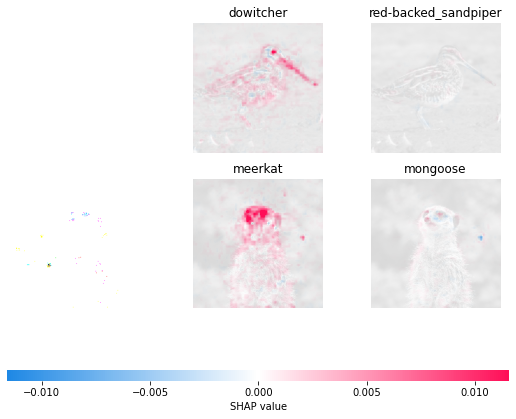

In [39]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

## 🧮 Model agnostic

SHAP library supports model agnostic explainer, which can be used for any model. It is based on the  weighted local linear regression and can be applied to any model that can be called with a set of input samples.

This can be practical for the models that are not supported by the standart methods, but **simple and fast enough to be called multiple times**

Below we have a toy example with Iris dataset and a several different models.

In [47]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import time

X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)

# rather than use the whole training set to estimate expected values, we could summarize with
# a set of weighted kmeans, each weighted by the number of points they represent. But this dataset
# is so small we don't worry about it
#X_train_summary = shap.kmeans(X_train, 50)

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

In [53]:
import warnings
warnings.filterwarnings("ignore")

#### KNN

In [54]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, Y_train)

print_accuracy(knn.predict)

Accuracy = 96.66666666666667%


In [55]:
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/30 [00:00<?, ?it/s]

#### SVM

In [56]:
svc_linear = sklearn.svm.SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, Y_train)
print_accuracy(svc_linear.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Accuracy = 100.0%


Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

#### Small NN

In [57]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

# explain all the predictions in the test set
explainer = shap.KernelExplainer(nn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Accuracy = 100.0%


Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]